### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


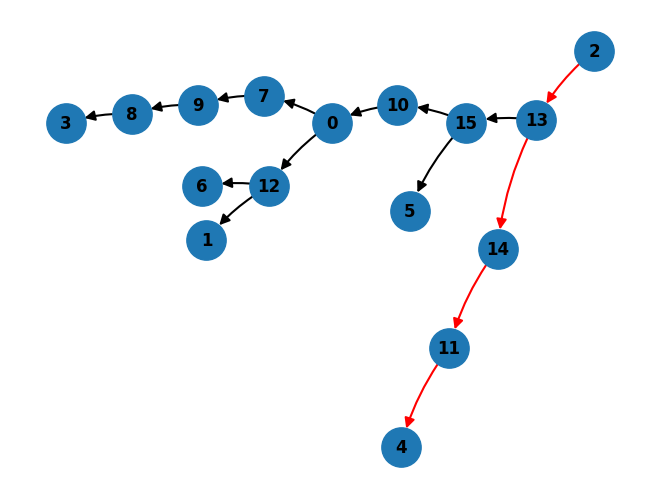

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

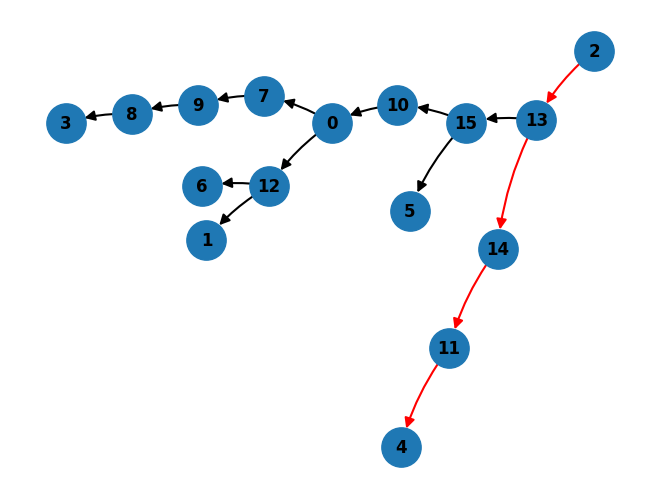

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [7]:
labels, cache = get_example_cache(pred, model, dataset)

In [8]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: understanding embeddings

In [9]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score

X = all_nodes
y = np.zeros((32,))
y[16:] = 1.0

probe = LinearRegression().fit(X, y)
# Calculate train loss
y_pred = probe.predict(X)
loss = mean_squared_error(y, y_pred)
loss

1.3222756223285614e-13

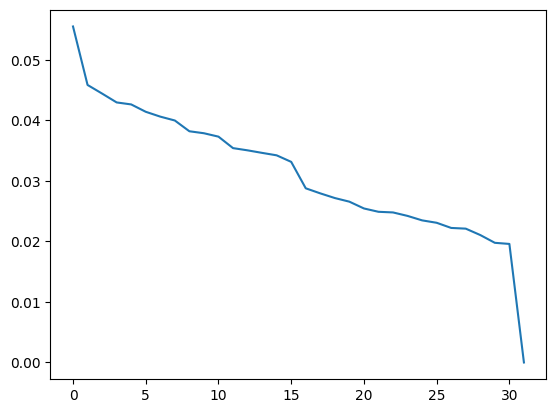

In [11]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(all_nodes)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score

X = all_nodes
y = np.zeros((32,))
y[16:] = 1.0

probe = LinearRegression().fit(X, y)
# Calculate train loss
y_pred = probe.predict(X)
loss = mean_squared_error(y, y_pred)
loss

1.3222756223285614e-13

In [13]:
def add_low_rank_hook(layer, k):
    
    X = []

    for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{layer}.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])

    X = torch.cat(X, dim=0).detach().cpu().numpy()

    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X)

    # Add low-rank hook

    from functools import partial

    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre


    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [14]:
model.reset_hooks()
add_low_rank_hook(1, 16)
add_low_rank_hook(2, 16)
add_low_rank_hook(3, 16)
add_low_rank_hook(4, 16)
add_low_rank_hook(5, 16)

In [15]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.0000%
random: 100.0000%


In [16]:
X = []

for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{1}.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])

X = torch.cat(X, dim=0).detach().cpu().numpy()


In [17]:
pca_128 = PCA(n_components=128)  # k is the desired rank of the approximation
pca_128 = pca.fit(X)

In [18]:
pca_16 = PCA(n_components=16)  # k is the desired rank of the approximation
pca_16 = pca.fit(X)

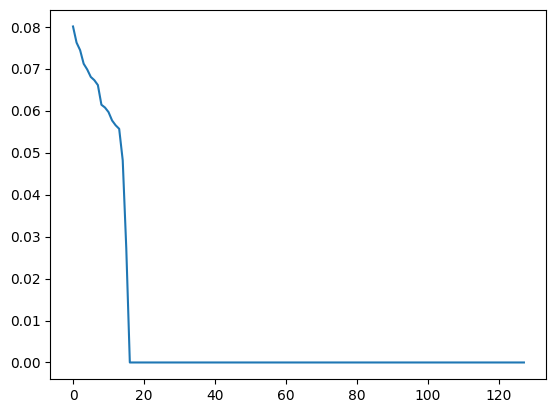

In [19]:
explained_variance = pca_16.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [20]:
pca_16.n_components_

128

In [21]:
imshow(pca_128.components_[0:16])

In [22]:
test_graph = generate_example(n_states, i, order="random")

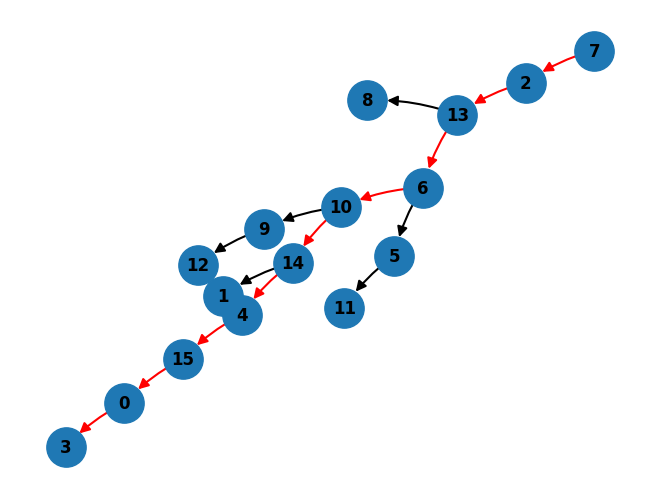

In [23]:
parse_example(test_graph)

In [24]:
ablated_edges, important_edges=attention_knockout_discovery(model, dataset, test_graph)


Breaking: Layer 5 head 0, labels[47] attending to labels[31], 7 attending to >6
Breaking: Layer 5 head 0, labels[48] attending to labels[31], >2 attending to >6
Breaking: Layer 5 head 0, labels[48] attending to labels[22], >2 attending to >4
Breaking: Layer 5 head 0, labels[49] attending to labels[22], >13 attending to >4
Breaking: Layer 4 head 0, labels[47] attending to labels[45], 7 attending to 3
Breaking: Layer 4 head 0, labels[47] attending to labels[38], 7 attending to ,
Breaking: Layer 4 head 0, labels[47] attending to labels[37], 7 attending to >5
Breaking: Layer 4 head 0, labels[47] attending to labels[36], 7 attending to 6
Breaking: Layer 4 head 0, labels[47] attending to labels[31], 7 attending to >6
Breaking: Layer 4 head 0, labels[47] attending to labels[25], 7 attending to >10
Breaking: Layer 4 head 0, labels[47] attending to labels[22], 7 attending to >4
Breaking: Layer 4 head 0, labels[47] attending to labels[19], 7 attending to >14
Breaking: Layer 4 head 0, labels[47] 

In [25]:
edge_list = important_edges.values() 

In [26]:
list(edge_list)

[[(0, 3, 2),
  (0, 4, 3),
  (0, 7, 6),
  (0, 9, 2),
  (0, 12, 2),
  (0, 19, 18),
  (0, 22, 21),
  (0, 24, 2),
  (0, 25, 24),
  (0, 30, 2),
  (0, 31, 30),
  (0, 33, 8),
  (0, 34, 33),
  (0, 35, 2),
  (0, 36, 36),
  (0, 36, 24),
  (0, 36, 13),
  (0, 37, 31),
  (0, 37, 28),
  (0, 37, 27),
  (0, 37, 24),
  (0, 37, 23),
  (0, 37, 22),
  (0, 37, 14),
  (0, 37, 10),
  (0, 37, 7),
  (0, 37, 6),
  (0, 37, 5),
  (0, 37, 4),
  (0, 38, 36),
  (0, 38, 35),
  (0, 38, 34),
  (0, 38, 33),
  (0, 38, 32),
  (0, 38, 31),
  (0, 38, 30),
  (0, 38, 29),
  (0, 38, 28),
  (0, 38, 26),
  (0, 38, 25),
  (0, 38, 24),
  (0, 38, 23),
  (0, 38, 22),
  (0, 38, 20),
  (0, 38, 19),
  (0, 38, 18),
  (0, 38, 17),
  (0, 38, 16),
  (0, 38, 11),
  (0, 38, 8),
  (0, 38, 7),
  (0, 39, 39),
  (0, 39, 38),
  (0, 39, 36),
  (0, 39, 32),
  (0, 39, 30),
  (0, 39, 29),
  (0, 39, 27),
  (0, 40, 39),
  (0, 40, 31),
  (0, 40, 28),
  (0, 40, 25),
  (0, 40, 22),
  (0, 40, 17),
  (0, 40, 16),
  (0, 40, 13),
  (0, 40, 10),
  (0, 40, 7),


In [27]:
modified_list = [tuple_[1:] for tuple_ in edge_list]

In [28]:
modified_list

[[(0, 4, 3),
  (0, 7, 6),
  (0, 9, 2),
  (0, 12, 2),
  (0, 19, 18),
  (0, 22, 21),
  (0, 24, 2),
  (0, 25, 24),
  (0, 30, 2),
  (0, 31, 30),
  (0, 33, 8),
  (0, 34, 33),
  (0, 35, 2),
  (0, 36, 36),
  (0, 36, 24),
  (0, 36, 13),
  (0, 37, 31),
  (0, 37, 28),
  (0, 37, 27),
  (0, 37, 24),
  (0, 37, 23),
  (0, 37, 22),
  (0, 37, 14),
  (0, 37, 10),
  (0, 37, 7),
  (0, 37, 6),
  (0, 37, 5),
  (0, 37, 4),
  (0, 38, 36),
  (0, 38, 35),
  (0, 38, 34),
  (0, 38, 33),
  (0, 38, 32),
  (0, 38, 31),
  (0, 38, 30),
  (0, 38, 29),
  (0, 38, 28),
  (0, 38, 26),
  (0, 38, 25),
  (0, 38, 24),
  (0, 38, 23),
  (0, 38, 22),
  (0, 38, 20),
  (0, 38, 19),
  (0, 38, 18),
  (0, 38, 17),
  (0, 38, 16),
  (0, 38, 11),
  (0, 38, 8),
  (0, 38, 7),
  (0, 39, 39),
  (0, 39, 38),
  (0, 39, 36),
  (0, 39, 32),
  (0, 39, 30),
  (0, 39, 29),
  (0, 39, 27),
  (0, 40, 39),
  (0, 40, 31),
  (0, 40, 28),
  (0, 40, 25),
  (0, 40, 22),
  (0, 40, 17),
  (0, 40, 16),
  (0, 40, 13),
  (0, 40, 10),
  (0, 40, 7),
  (0, 40, 1),

In [29]:
G = nx.DiGraph(modified_list)

NetworkXError: Input is not a valid edge list

In [ ]:
model.reset_hooks()

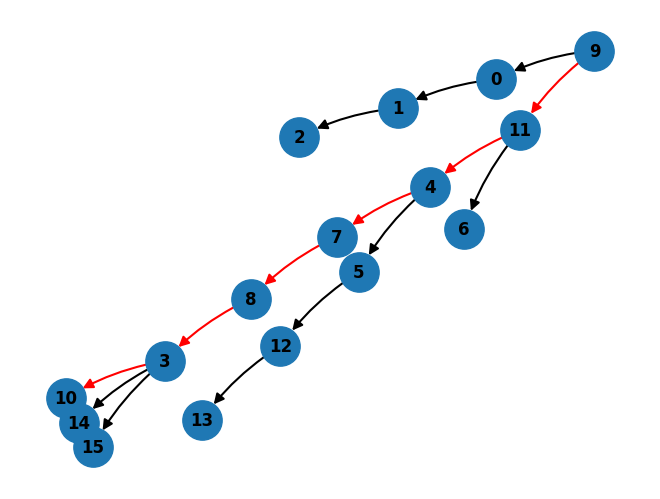

In [ ]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

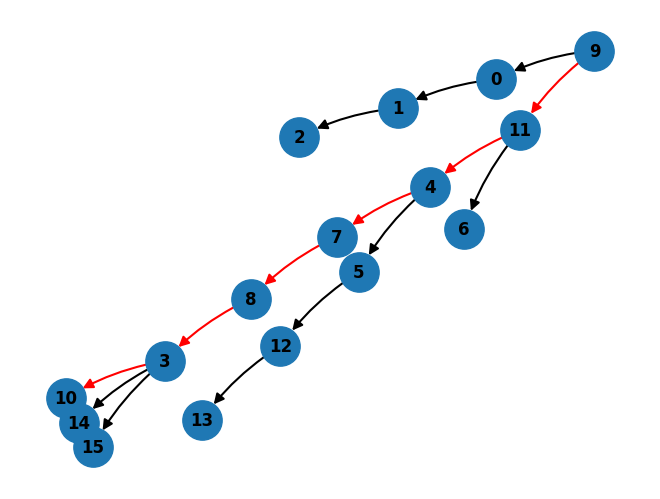

In [ ]:
parse_example(pred)

In [ ]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt

In [ ]:
for i in range(16):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    logit_lens(corrupted_prompt, model, dataset)

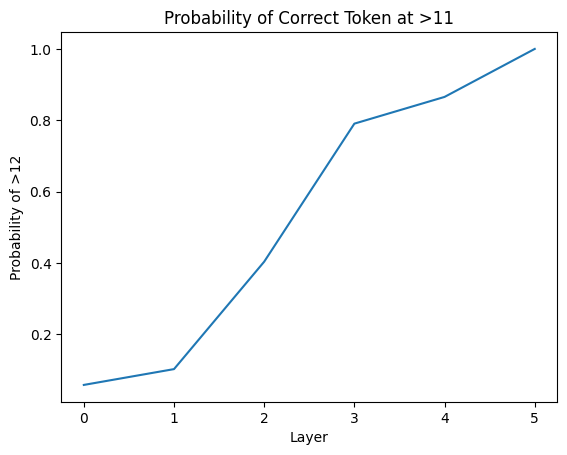

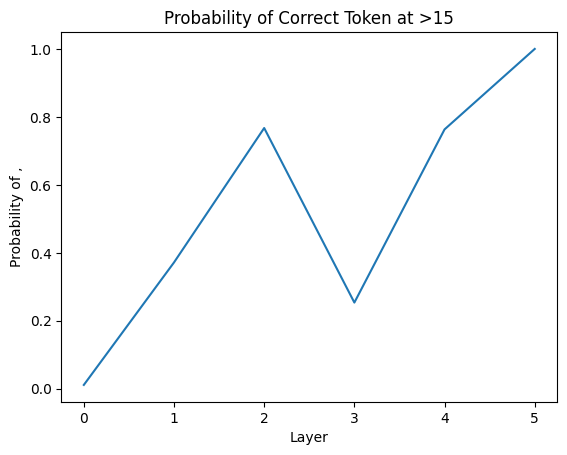

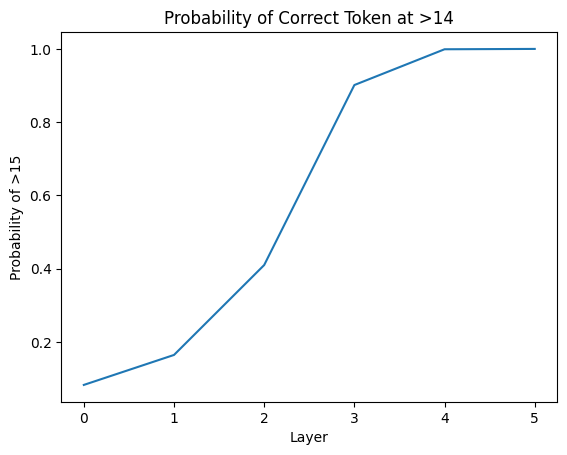

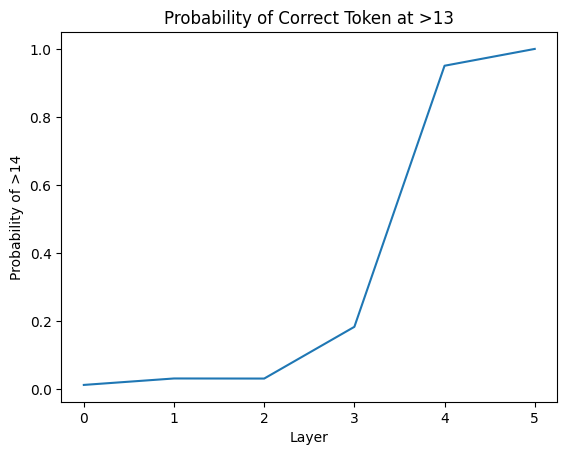

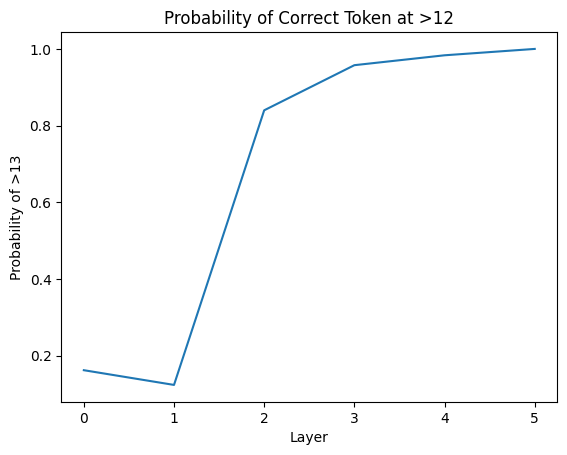

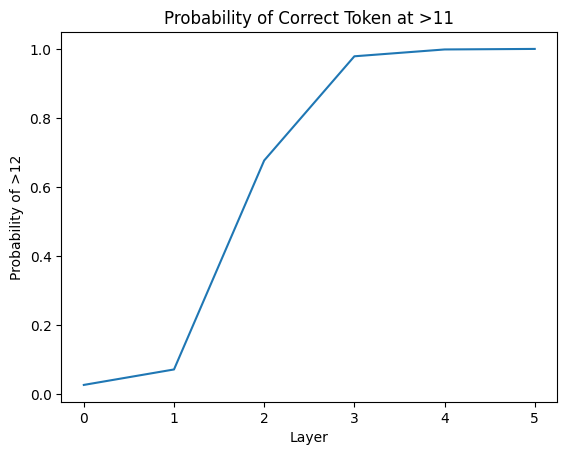

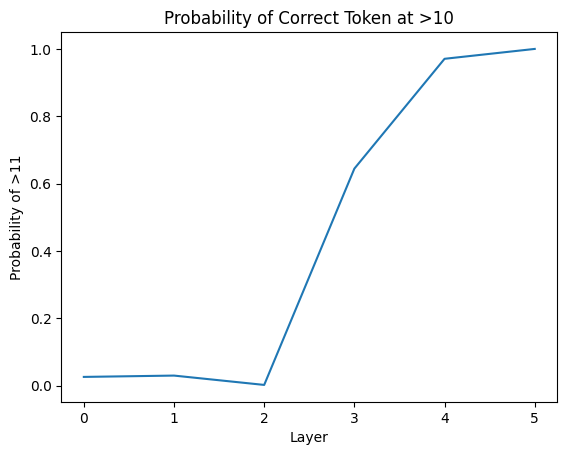

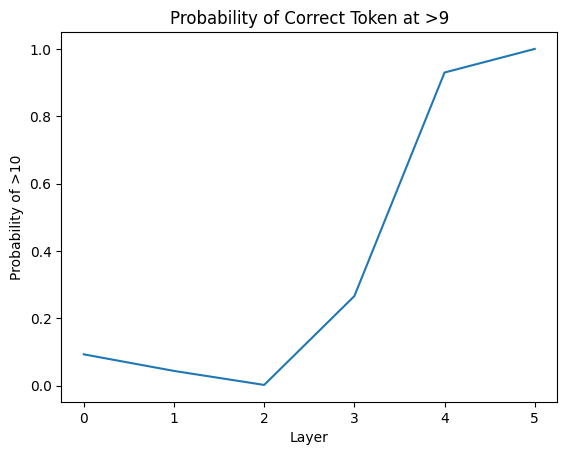

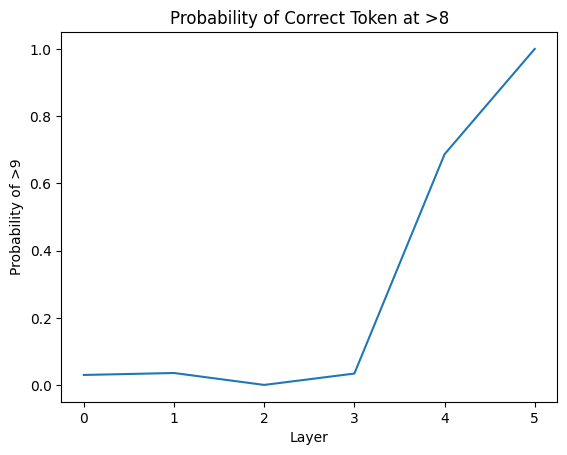

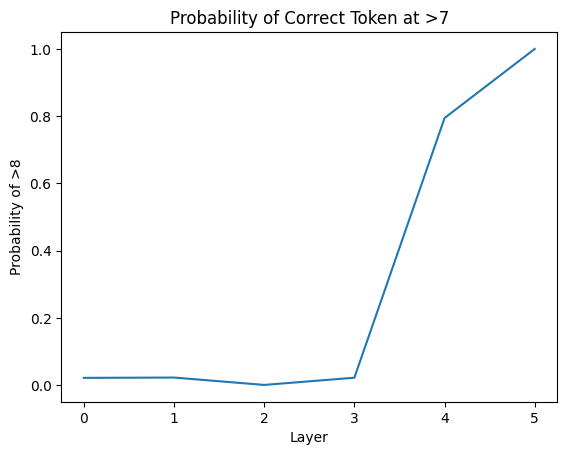

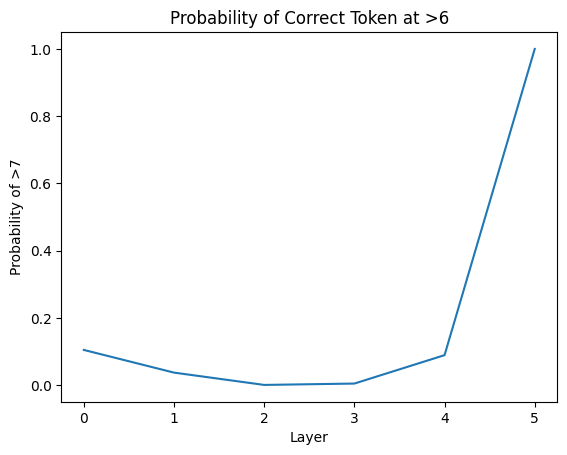

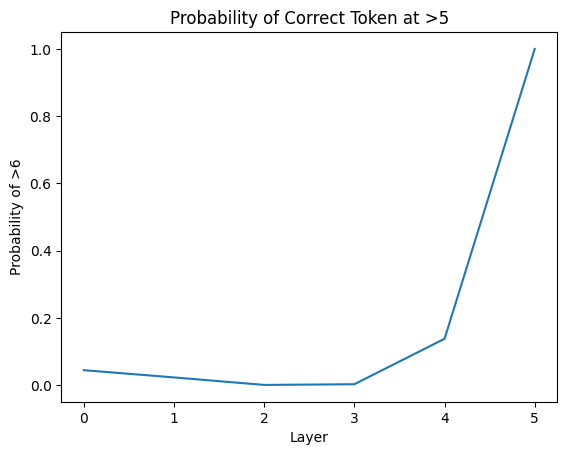

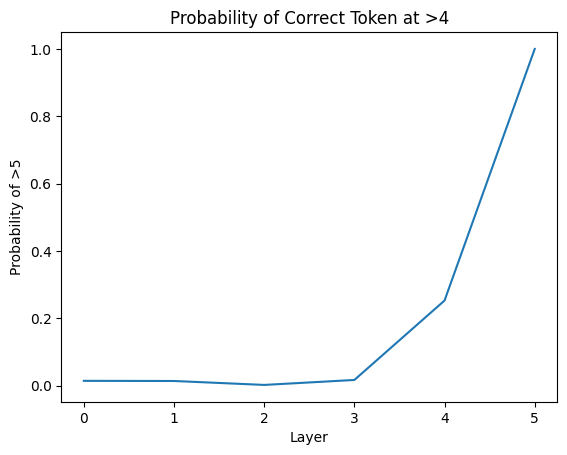

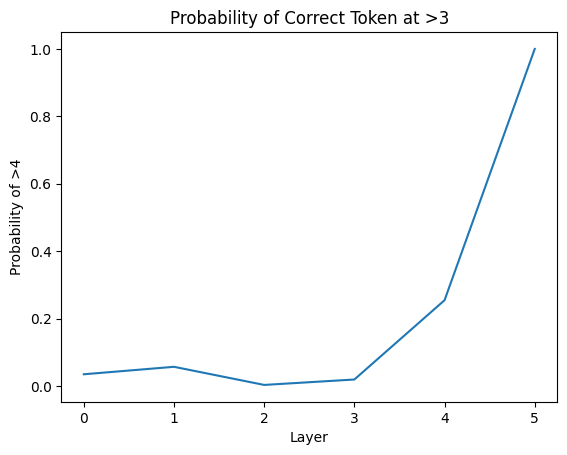

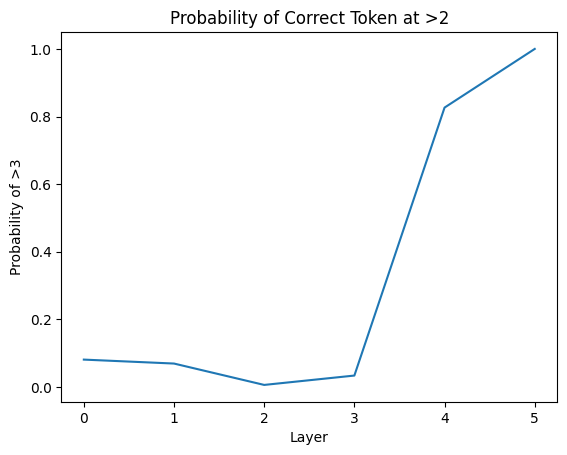

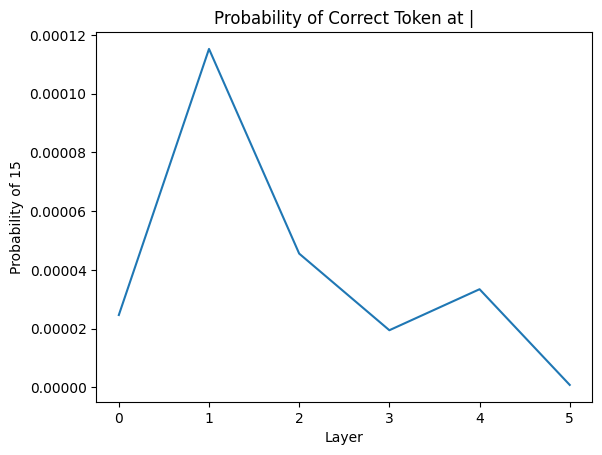

In [ ]:
for i in range(16):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    logit_lens_correct_probs(corrupted_prompt, model, dataset,46 + (15 - i + 1))

In [ ]:
def logit_lens_correct_probs_result(pred, model, dataset, position):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    # Get the probability of the correct next token at every layer
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers + 1):
        if layer < model.cfg.n_layers:
            res_stream = cache[utils.get_act_name("normalized", layer, "ln1")][0]
        else:
            res_stream = cache["ln_final.hook_normalized"][0]
        out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs


In [ ]:
heatmap=[]
for i in range(16):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    logit_lens_correct_probs_result(corrupted_prompt, model, dataset,46 + (15 - i + 1))
prompts

In [ ]:
clean_prompt, corrupted_prompt= generate_goal_distance_examples(0)

In [ ]:
corrupted_prompt

'0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15,14>16|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14'

In [ ]:
logit_lens_correct_probs(pred, model, dataset)

TypeError: logit_lens_correct_probs() missing 1 required positional argument: 'position'